# Backgroud Least Squares

El planteamiento del algoritmo de posicionamiento cooperativo esta apoyado en la técnica númerica de mínimos cuadrados, de forma que la asociación de la terminología y planteamiento pueden facilitar la comprensión de la técnica de posicionamiento propuesta en esta investigación.

El plantemiento de mínimos cuadrados establece un proceso de linearización al modelo no lineal asociado al pseudorango existente entre un receptor GPS y un satélite visible desde su ubicación, con lo cual, una observación GPS obtenida por el receptor puede ser considerada como:


\begin{equation}
\begin{aligned}
P_{obs} &= pseudorango_{modelo} + ruido \\
        &= P(x,y,z,\tau) + \eta
\end{aligned}
\end{equation}

Aplicar la expansión de series de taylor al modelo de pseudorango, alrededor de un punto de operación $(x_o, y_o, z_o, \tau_o)$ e ignorando los términos de orden superior y errores de truncamiento asociados, el modelo de pseudorango sería definido como:

\begin{equation}
\begin{aligned}
P(x,y,z,\tau) &= P(x_o,y_o,z_o,\tau_o) 
                 +(x-x_o){\frac{\partial P}{\partial x}}
                 +(y-y_o){\frac{\partial P}{\partial y}}
                 +(z-z_o){\frac{\partial P}{\partial z}}
                 +(\tau-\tau _o){\frac{\partial P}{\partial \tau}} \\
        &= P(x_o,y_o,z_o,\tau_o) 
                 +{\frac{\partial P}{\partial x}} \Delta x 
                 +{\frac{\partial P}{\partial y}} \Delta y
                 +{\frac{\partial P}{\partial z}} \Delta z 
                 +{\frac{\partial P}{\partial \tau}}\Delta \tau  \\
\end{aligned}
\end{equation}

Al plantear la diferencia (el error) entre los valores observados de distancia y el modelo linearizado de pseudorango, se obtiene una expresión:

\begin{equation}
\begin{aligned}
\Delta P &= (\frac{\partial P}{\partial x}, \frac{\partial P}{\partial y}, \frac{\partial P}{\partial t},\frac{\partial P}{\partial \tau})
            (\Delta x \Delta y \Delta z \Delta \tau)^{T} \\
         &= A*\Delta X 
\end{aligned}
\end{equation}

donde:
\begin{itemize}
* $ \Delta P = P_{obs} - P(x_o,y_o,z_o,\tau_o)$
* $A$ Matriz de cosenos directores
* $ \Delta X = (\Delta x \Delta y \Delta z \Delta \tau)^{T}$
\end{itemize}

In [1]:
from sympy import *
%matplotlib inline
init_printing(use_latex=True)
%run -i ../../code/WallasUtils.py
#%run -i ../../code/utils.py
%run -i ../../code/Wallas_symbolic_utils.py
%run -i ../../code/multirover4.py

In [4]:
n_vars = 4
n_sats = 4

Dist, Ad = create_distance_matrix("a", "b", "b")
Aa, Pa, Xa = create_matrix_x_receiver("a", n_sats=n_sats)
Ab, Pb, Xb = create_matrix_x_receiver("b", n_sats=n_sats)

# Planteamiento para posicionamiento autónomo

## El modelo de pseudorango asumido

En cuanto al modelo de pseudorango $\rho^{i}$ considerado para el presente estudio, se considera que el modelo involucra la distancia geométrica hasta el satélite visible y el error de sincronización en el reloj del receptor $\tau_a$, los términos asociados a fenomenos ionosféricos, troposféricos y demás, son agrupados como parte del término de error $\nu_i$.

Como caso concreto, los pseudorangos a cuatro satélites desde el receptor $a$ serán:

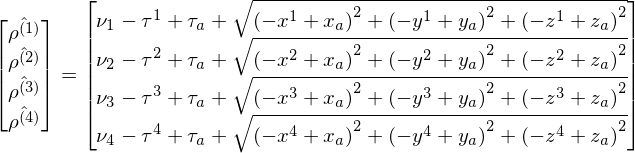

In [5]:

rhos   = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho^{(%d)}}' % (i+1)))
nu     = Matrix(n_sats, 1, lambda i,j:var('\\nu_{%d}'%(i+1) ))

vnames  = ["x", "y", "z", "\\tau"]
x0     = Matrix(Xa.shape[0],1, lambda i,j: var(vnames[i]+"_0"))

#rhos,Pa,nu
Eq(rhos,Pa+nu)

Para efectos demostrativos, en esta sección del documento se ha asume que $\nu_{i} = 0$ para los receptores que conforman la pareja en posicionamiento cooperativo. Con posterioridad se estudiará el efecto asociado a variaciones en este término del modelo de pseudorando.

De forma que el modelo de pseudorango simplificado y a considerar, queda definido como:

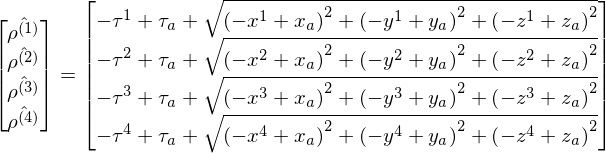

In [9]:
Pc_a, Pc_b = Pa, Pb
Eq(rhos,Pc_a)

## vector de residuales

Partiendo del planteamiento de mínimos cuadrados el término $\Delta P$, asociado a la diferencia entre el observable obtenido en el receptor $P_{obs} $y el modelo de pseudorango $\rho_i$, es también conocido como vector de residuales. 

Para el caso particular de posicionamiento autónomo, se puede apreciar que:

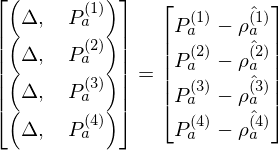

In [12]:
n, m = 2*n_sats+1, 2*n_vars#+3

# create a symbolic matrix for construct A matrix
A  = Matrix(MatrixSymbol("A",n, m))
# component asociated to position of local receiver
A[:n_sats,:n_vars:] = Aa
A[:n_sats,n_vars:] = np.zeros(np.shape(A[:n_sats,n_vars:]))

# component asociated to position of remote receiver
A[n_sats:-1,n_vars:] = Ab
A[n_sats:-1,:n_vars] = np.zeros(np.shape(A[n_sats:-1,:n_vars]))

# component asociated to distance between receivers
A[-1,:] = np.hstack((zeros(1,4), 2*Ad[:,:3], zeros(1,1)))

# create left side vector
Ps = Matrix(MatrixSymbol("P",n_sats, 1))
Psa = Matrix(n_sats, 1, lambda i,j:var('\Delta P_{%s}^{(%d)}' % ('a', i+1)))
rho_a = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('a', i+1)))
Pda = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('a', i+1)))

Eq(Psa, Pda - rho_a)
#Ps[:n_sats,:], Pc_a

## definiendo la matriz de cosenos directores

Igualmente las expresiones para los cosenos directores a cada uno de los satélites vistos desde un receptor; para efectos prácticos y de un caso en particular, se considera que el receptor $A$ tiene visibilidad a 4 Satélites ubicados en posiciones $x_i, y_i, z_i$ (i=1..4), entonces su matriz de cosenos directores  será:

In [ ]:
Aa

Si se considerará la solución de posicionamiento autonómo para el receptor $A$, este sistema de ecuaciones comprende un sistema de ecuaciones determinado para el cúal obtendrían soluciones fijas $x_a, y_a, z_a, \tau_a$. Sin embargo es de aclarar que, un receptor GPS hoy día puede observar en promedio 8 a 9 satélites a lo largo de un día, con lo cúal el sistema de ecuaciones anterior se convierte en un sistema sobredeterminado con múltiples soluciones, de las cuales interesa la solución para la cúal, la diferencia entre los valores calculados y los medidos desde el receptor sean mínimas; para ello, se hace uso de una técnica númerica como mínimos cuadrados para obtener soluciones númericas basadas en dicho criterio de minimizar el error del estimado de posición.


\begin{equation}
\begin{aligned}
         \hat{e} = min(b - A*\Delta X) 
\end{aligned}
\end{equation}

# Planteamiento para posicionamiento cooperativo

El planteamiento para el algoritmo cooperativo parte de considerar la distancia entre dos receptores GPS como información útil para contribuir a la precisión en el posicionamiento de los receptores en cuestión.

La distancia entre los receptores es considerada como una variable de control, que puede ser obtenida con la ayuda de sensores de distancia ubicados en los receptores GPS o ser calculada a partir de las coordenadas obtenidas de la tarea de posicionamiento autonomo de cada receptor. La distancia estimada por cualquiera de estas dos alternativas conllevará un nivel de error asociado a su valor, por ende la propagación de su incertidumbre al momento de ser empleada para calcular las posiciones de los receptores en el metodo cooperativo, es considerada como un objeto de estudio en el apartado experimental del proyecto.

Por lo pronto para efectos del planteamiento matematico se considera que el error sobre este estimado de distancia sera despreciable ($\epsilon(d)=0)$).

De forma que la distancia estimada entre dos receptores A($x_a, y_a, z_a$) y B($x_b, y_b, z_b$) estará definida como:


In [14]:
n, m = 2*n_sats+1, 2*n_vars#+3

# create a symbolic matrix for construct A matrix
A  = Matrix(MatrixSymbol("A",n, m))
# variables to solve
dx = Matrix(MatrixSymbol("\\Delta",m, 1))
# create left side vector ( ranges to sats from receivers)
Ps = Matrix(MatrixSymbol("P",n, 1))
vnames = ["x", "y", "z", "\\tau"]
O_sats = Matrix(n, Xa.shape[0], lambda i,j:var(vnames[j]+'^{%d}' % (i+1)))

# component asociated to position of local receiver
A[:n_sats,:n_vars:] = Aa
A[:n_sats,n_vars:] = np.zeros(np.shape(A[:n_sats,n_vars:]))

# component asociated to position of remote receiver
A[n_sats:-1,n_vars:] = Ab
A[n_sats:-1,:n_vars] = np.zeros(np.shape(A[n_sats:-1,:n_vars]))

# component asociated to distance between receivers
A[-1,:] = np.hstack((zeros(1,4), 2*Ad[:,:3], zeros(1,1)))

#for i, x in enumerate(A[-1,:]):
#    A[-1,i] = x*pow(Dist, -1)

# create left side vector
Psa = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('a', i+1)))
Psb = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('b', i+1)))
Psd = Matrix(1, 1, lambda i,j:var('d_{%s%s}' % ('a', 'b')))

Ps[:n_sats, :]   = Psa
Ps[n_sats:-1, :] = Psb
Ps[-1] = Psd

# range model 
rhos_a = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('a', i+1)))
rhos_b = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('b', i+1)))

In [ ]:
2*Dist[0]

La expresión anterior formará parte del vector de residuales empleado para el posicionamiento cooperativo.

## Coseno director asociado a la distancia entre receptores

Considerando que la posición de un receptor GPS es producto de dar solución a un sistema de ecuaciones algebraicas no lineales, que describen las distancias existentes entre el receptor y cada uno de los satelites visibles desde su ubicación y que es resuelto de forma iterativa con la ayuda de métodos numéricos. 

El algoritmo cooperativo toma en cuenta relaciones algebraicas adicionales, relacionadas con el conjunto de satélites visibles en común para una dupla de receptores GPS; de manera similar a como se conciben los planteamientos de posicionaiento diferencial. Las relaciones algebraicas adicionales, describen la ligadura asociada a la distancia existente entre el par de receptores que conforma una dupla cooperativa.

De forma que las variaciones en las coordenadas estimadas de un receptor, se veran reflejadas en la posición de su semejante a traves de la relación de distancia existente entre sí y su respectivo coseno director, definido de la siguiente manera:

In [ ]:
2*Ad[0], 2*Ad[1], 2*Ad[2]

Esta expresión formará parte de la matrix de cosenos directores construida para llevar a cabo posicionamiento cooperativo. 

## Modelo de pseudorango

El modelo de pseudo-distancia asumido para una pareja de receptores $a$ y $b$ que trabajan de manera cooperativa para posicionarse, es concebido como la agrupación de sus modelos de pseudo-distancia definidos para el ámbito autónomo.

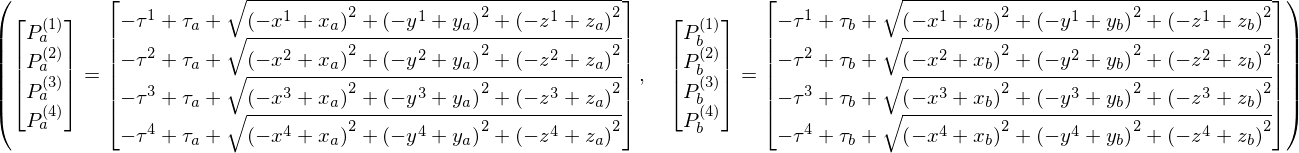

In [15]:
Paa = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('a', i+1)))
Pab = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('b', i+1)))

rho_a = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('a', i+1)))
rho_b = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('b', i+1)))

Eq(Paa, Pa), Eq(Pab, Pb)

## El vector de residuales

De manera análoga al planteamiento del posicionamiento autónomo, el vector de residuales$\Delta P$ contempla la agrupación de los vectores de residuales autónomos para cada uno de los receptores que conforman una dupla de receptores trabajando en ámbito cooperativo. (ej: receptores a y b, son una dupla cooperativa). 

In [31]:
PD  = Matrix(MatrixSymbol("P",n, 1))
Pda = Matrix(n_sats, 1, lambda i,j:var('\Delta P_{%s}^{(%d)}' % ('a', i+1)))
Pdb = Matrix(n_sats, 1, lambda i,j:var('\Delta P_{%s}^{(%d)}' % ('b', i+1)))
Pdd = Matrix(1, 1, lambda i,j:var('\Delta d_{%s%s}' % ('a', 'b')))

PD[:n_sats, :]   = Pda
PD[n_sats:-1, :] = Pdb
PD[-1] = Pdd

rho_a = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('a', i+1)))
rho_b = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('b', i+1)))

rho = Matrix(MatrixSymbol("P_comp",n, 1))
rho[:n_sats, :]   = rho_a
rho[n_sats:-1, :] = rho_b
rho[-1] = Matrix(1, 1, lambda i,j:var(' \hat{d_{%s%s}}' % ('a', 'b')))


Pm = Matrix(MatrixSymbol("P_mod",n, 1))
Pm[:n_sats, :]   = Ps[:n_sats, :] - Pc_a
Pm[n_sats:-1, :] = Ps[n_sats:-1, :] - Pc_b
Pm[-1]           = Psd[-1, :] - 2*Dist

Asym = A
bsym = Ps - rho

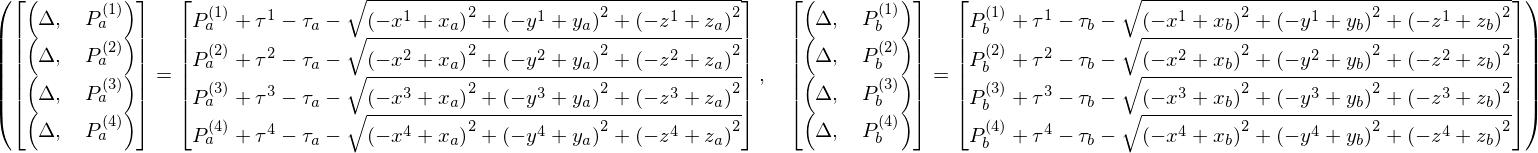

In [32]:
Eq(Pda, Pm[:n_sats, :]), Eq(Pdb, Pm[n_sats:-1, :])

Para el caso particular de posicionamiento cooperativo, se puede apreciar que:

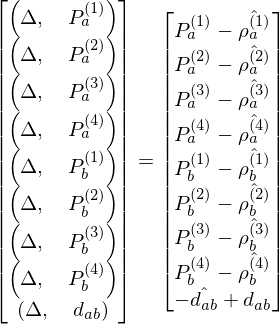

In [26]:


Eq(PD, bsym)#, Pm


Adicionalmente, el término asociado con el coseno director de la distancia entre los receptores que conforman una dupla cooperativa, forma parte del vector de residuales. Por ello por cada dupla de receptores que se conforma en el ámbito cooperativo, el vector de residuales tendrá una fila adicional en la cual se establece la diferencia entre el observable de distancia y su respectivo modelo algebraico.

## Contruyendo matriz de posicionamiento cooperativo

Con el propósito de establecer una relación de distancia entre receptores y sus cosenos directores al conjunto de satélites visibles, se considera un par de receptores GPS observa un conjunto de satélites en común, el cúal define un sistema de ecuaciones que tendrá soluciones siempre y cuando, el número de satélites visibles en común sea $n_{sats} >= 4$, siendo posible determinar las variables $($x_a, y_a, z_a, \tau_a$) y ($x_b, y_b, z_b, \tau_b$)$ de manera simultanea.


Por ello, al considerar la construcción de la matriz de cosenos directores en el ámbito cooperativo entre una pareja de receptores, se agrupan las matrices de cosenos directores individuales y finalmente se añade la relación de coseno directores asociada a la distancia entre ellos, así las posiciones $($x_a, y_a, z_a, \tau_a$) y ($x_b, y_b, z_b, \tau_b$)$ serán calculadas bajo el criterio de distancia (considerando la variable de control).

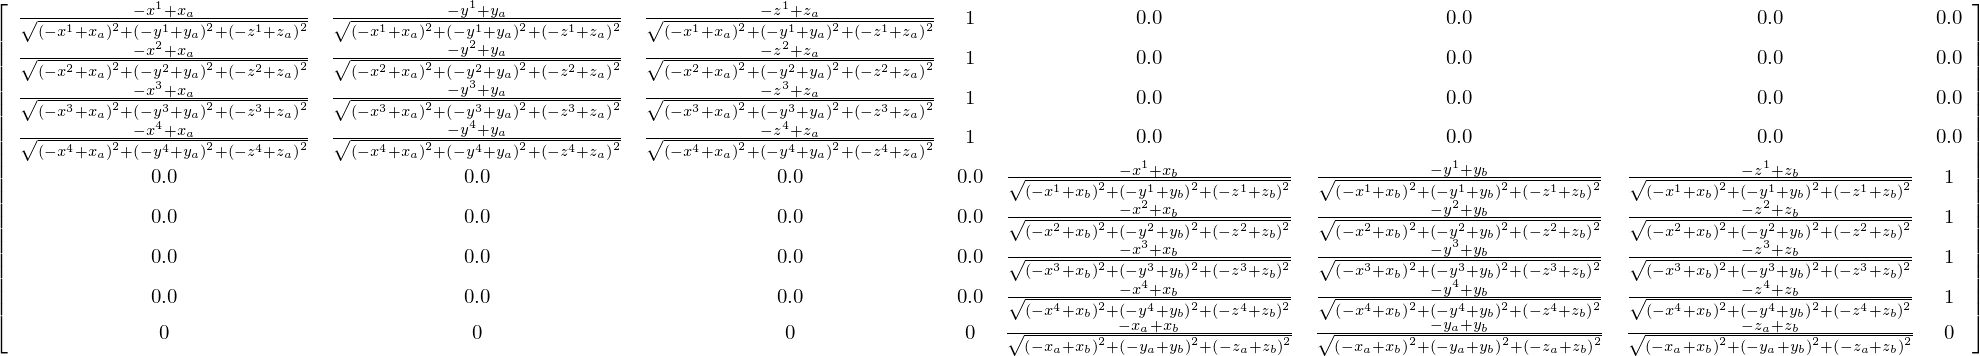

In [27]:
A

Para efector demostrativos, el ejemplo presentado en esta sección se han considerado un par de receptores que observan 4 satélites en común; y para los cuales la última fila de la matriz hace referencia al coseno director de la distancia entre ellos.

Cabe recordar que la distancia euclidiana entre las coordenadas ecef (XYZ) entre dos receptores no involucra variables en el dominio del tiempo, por lo tanto, la fila adicional no tendrá derivada parcial con respecto a la desciación de reloj en tiempo GPS.


# Resumen de Capítulo

El método de mínimos cuadrados para ámbito cooperativo, toma como base los planteamientos para posicionamiento autónomo y posicionamiento diferencial entre una dupla de receptores. 


## El número de satélites visibles
De forma que el número de satélites visibles en común puede ser inferior al visto de manera independiente por cada receptor, así pues, para los receptores que conforman una dupla trabajando en ámbito cooperativo y que busque mejorar su precisión en posicionamiento, requere de minimo 5 satélites visibles en común para obtener soluciones a los parametros $x, y, z, \tau  y  d$. 

## Las caracteristicas de la matriz de posicionamiento cooperativo

### la matrix es simetríca?? indenpotente 
El método cooperativo concedido para el desarrollo de este trabajo, se construye a partir de la agrupación de los vectores de residuales y matrices de cosenos directores de cada uno de los receptores que conforman la dupla cooperativa, de forma que, los elementos que conforman la diagonal de la matriz de posicionamiento cooperativo son las matrices de cosenos directores de cada uno de los receptores en interacción. 

### Las dimensiones de la matriz cooperativa
Las filas y columnas de la matriz de posicionamiento cooperativo son múltiplos del numero de receptores en interacción. Adicionalmente, el número de filas incrementará en una unidad a medida que se adicionen receptores conjunto de receptores cooperativos, ya que por cada dupla que se conforma existe un coseno director de la distancia entre cada dupla de receptores.

### Las correlaciones y autocorrelaciones
Para efectos del planteamiento de este estudio, no se han considerado correlaciones ni correlaciónes entre receptores u observables de posicionamiento obtenidos por los receptores. Por tal razón, gran parte de los elementos en las diagonales superiores e inferiores de la matriz de posicionamiento cooperativo son asumidos como ceros. 

## Reemplazando valores simbolicos por observados

In [ ]:
%reset -f

In [ ]:
from sympy import *
%matplotlib inline
init_printing(use_latex=True)
%run -i ../../code/WallasUtils.py
#%run -i ../../code/utils.py
%run -i ../../code/Wallas_symbolic_utils.py
%run -i ../../code/multirover4.py

In [ ]:
## archivos rinex a utilizar

obsfile1 = "./../../NavFiles/unpm0100.17o" 
navfile1 = "./../../NavFiles/unpm0100.17n" 

obsfile2 = "./../../NavFiles/tgmx0100.17o"
navfile2 = "./../../NavFiles/tgmx0100.17n"

# data, bcestore, rec_pos = rinex_to_dataframe(obsfile, navfile)
data1, bcestore1, rec_pos1 = rinex_to_dataframe_ionosfe(obsfile1, navfile1)
# data, bcestore, rec_pos = rinex_to_dataframe(obsfile, navfile)
data2, bcestore2, rec_pos2 = rinex_to_dataframe_ionosfe(obsfile2, navfile2)

data_common = extract_common2(data1, data2)

In [ ]:
init_printing(use_latex=True)

epoc = 0
o = data_common.iloc[epoc]

n_sats = len(o.csats)
n_vars = 4

n, m = 2*n_sats+1, 2*n_vars#+3

In [ ]:
psats_a, pr_a = extract_info_rx(o, origin="local")
psats_b, pr_b = extract_info_rx(o, origin="remote")

%run -i ../../code/Wallas_Solvers.py
dc, teta, dc_vecr = d_teta_calc(rec_pos2, rec_pos1)

Dist, Ad = create_distance_matrix("a", "b", "b")
Aa, Pa, Xa = create_matrix_x_receiver("a", n_sats=n_sats)
Ab, Pb, Xb = create_matrix_x_receiver("b", n_sats=n_sats)

# create a symbolic matrix for construct A matrix
A  = Matrix(MatrixSymbol("A",n, m))
# component asociated to position of local receiver
A[:n_sats,:n_vars] = Aa
A[:n_sats,n_vars:] = np.zeros(np.shape(A[:n_sats,n_vars:]))

# component asociated to position of remote receiver
A[n_sats:-1,n_vars:] = Ab
A[n_sats:-1,:n_vars] = np.zeros(np.shape(A[n_sats:-1,:n_vars]))

# component asociated to distance between receivers
A[-1,:] = np.hstack((zeros(1,4), 2*Ad[:,:3], zeros(1,1)))

# Observed vector for computed distance from model
Pc = Matrix(MatrixSymbol("P_comp",n, 1))
Pc[:n_sats, :]   = Pa #Pc_a
Pc[n_sats:-1, :] = Pb #Pc_b
Pc[-1] = Dist  #d_est


# ordering observed position sats on observed matriz
O_sats_vals = Matrix(MatrixSymbol("XYZT",n, m))
O_sats_vals[:,:] = np.zeros(np.shape(O_sats_vals))
O_sats_vals[:n_sats,:n_vars] = psats_a
#O_sats_vals[n_sats:-1,n_vars:] = psats_b

# Observed vector for ranges observed from receivers
Prs_vals = Matrix(MatrixSymbol("Pr",n, 1))
Prs_vals[:n_sats,:]   = pr_a
Prs_vals[n_sats:-1,:] = pr_b
Prs_vals[-1] = dc

X0 = np.ones(4)
X1 = np.ones(4)

In [ ]:
vnames = ["x", "y", "z", "\\tau"]
O_sats = Matrix(n_sats, Xa.shape[0], lambda i,j:var(vnames[j]+'^{%d}' % (i+1)))
O_sats

In [ ]:
def evals(xvar, A_vals, P_computed, O_sats_vals, P_observed_vals, Ad_vals):

    for j in range(O_sats.shape[1]):
        #print j,
        A_vals = A_vals.subs({Xa[j]: xvar[j]})
        A_vals = A_vals.subs({Xb[j]: xvar[4+j]})
        Ad_vals = Ad_vals.subs({Xa[j]: xvar[j]})
        Ad_vals = Ad_vals.subs({Xb[j]: xvar[4+j]})

        P_computed = P_computed.subs({Xa[j]: xvar[j]})
        P_computed = P_computed.subs({Xb[j]: xvar[4+j]})

        for i in range(O_sats.shape[0]):
            #print i
            A_vals = A_vals.subs({O_sats[i,j]: O_sats_vals[i,j]})
            P_computed = P_computed.subs({O_sats[i,j]: O_sats_vals[i,j]})
    
    #A_vals
    b = -P_computed + P_observed_vals
    nA = lambdify( (), A_vals )()
    nb = lambdify( (), b      )()
    
    return b, nA, nb

In [ ]:
#O_sats_vals, 

In [ ]:
Ad_vals = 2*Ad
X0 = np.zeros(4)
X1 = np.ones(4)
xvar = np.hstack((X0, X1))
xvar = xvar.reshape(-1,1)

for i in range(len(Xa)):
    #print i,
    Ad_vals =  Ad_vals.subs({Xa[i]:X0[i]})
    Ad_vals =  Ad_vals.subs({Xb[i]:X1[i]})
#Ad_vals
O_sats_vals[-1,n_vars:] = Ad_vals

In [ ]:
#O_sats_vals

In [ ]:
for i in range(10):

    b, nA, nb = evals(xvar, A, Pc, O_sats_vals, Prs_vals, Ad)

    delta = np.linalg.lstsq(nA,nb)[0]
    xvar += delta
    #print xvar[:,0]

print "error Rover %s error Master %s " %(np.linalg.norm(xvar[:3,0] - rec_pos1), np.linalg.norm(xvar[4:7,0] - rec_pos2),)

## Solución iterativa LS

In [ ]:
X0 = np.zeros(4)
X1 = np.ones(4)

xvar = np.hstack((X0, X1))
xvar = xvar.reshape(-1,1)

P_observed_vals = Prs_vals

for i in range(10):
    A_vals = A
    Ad_vals = Ad
    P_computed = Pc
    
    for j in range(O_sats.shape[1]):
        #print j,
        A_vals = A_vals.subs({Xa[j]: xvar[j]})
        A_vals = A_vals.subs({Xb[j]: xvar[4+j]})
        Ad_vals = Ad_vals.subs({Xa[j]: xvar[j]})
        Ad_vals = Ad_vals.subs({Xb[j]: xvar[4+j]})
        
        P_computed = P_computed.subs({Xa[j]: xvar[j]})
        P_computed = P_computed.subs({Xb[j]: xvar[4+j]})

        for i in range(O_sats.shape[0]):
            #print i
            A_vals = A_vals.subs({O_sats[i,j]: O_sats_vals[i,j]})
            P_computed = P_computed.subs({O_sats[i,j]: O_sats_vals[i,j]})
    
    b = -P_computed + P_observed_vals
    nA = lambdify( (), A_vals )()
    nb = lambdify( (), b      )()

    delta = np.linalg.lstsq(nA,nb)[0]

    xvar += delta
    #print xvar[:,0]

print "error Rover %s error Master %s " %(np.linalg.norm(xvar[:3,0] - rec_pos1), np.linalg.norm(xvar[4:7,0] - rec_pos2),)

In [ ]:
a = np.zeros((9))
a[:2] = 1
a[2:5] = 2
a[5] = 3
a

In [ ]:
for i in enumerate(range(9)):
    print i,

# Comparación con la solución standalone

## para el receptor Rover

In [ ]:
%run -i ../code/code/Wallas_Solvers.py
%run -i ../code/utils.py
i = 0
o = data1.iloc[i]
pranges = o.C1

p1, clocks, pos = np.array(pranges), np.array(o.prns_clockbias), np.array(o.prns_pos)

dc, teta, dc_vec = d_teta_calc(rec_pos1, rec_pos2)
i = 0
dat = data_common.iloc[i]


raim_computed_pos         = compute_raim_position(o.gps_week, o.gps_sow, o.prns, o.prns_pos, pranges, bcestore2)
ls_computed_pos_ic,A,b,_  = compute_least_squares_position_ignore_clock(o.prns_pos, pranges)

idxs                      = np.arange(len(pranges))
p1, pos                   = pranges[idxs], o.prns_pos[idxs]
clocks                    = o.prns_clockbias[idxs]
ls_computed_pos,A,b,_     = compute_least_squares_position(pos, clocks, p1)

# Metodos desarrollados
#rs = Solver_standalone(pos, clocks, p1)
#rc = Solver_cooperative(dat, dc_vec, "C1", xo=np.array(list(rs.x[:3])+[0.]))

ls_octave_pos             = %octave -g -i p1,pos Rcv_Pos_Compute(pos,p1);

print ("Posicion Rx_%s = %s" %(obsfile1, rec_pos1))
print "--"
print "RAIM computed            ", raim_computed_pos, np.linalg.norm(raim_computed_pos - rec_pos1)
print "LS computed              ", ls_computed_pos[:3], np.linalg.norm(ls_computed_pos[:3] - rec_pos1)

## para el receptor Master

In [ ]:
%run -i ../code/Wallas_Solvers.py
%run -i ../code/utils.py
i = 0
o = data2.iloc[i]
pranges = o.C1

p1, clocks, pos = np.array(pranges), np.array(o.prns_clockbias), np.array(o.prns_pos)

dc, teta, dc_vec = d_teta_calc(rec_pos1, rec_pos2)
i = 0
dat = data_common.iloc[i]


raim_computed_pos         = compute_raim_position(o.gps_week, o.gps_sow, o.prns, o.prns_pos, pranges, bcestore2)
ls_computed_pos_ic,A,b,_  = compute_least_squares_position_ignore_clock(o.prns_pos, pranges)

idxs                      = np.arange(len(pranges))
p1, pos                   = pranges[idxs], o.prns_pos[idxs]
clocks                    = o.prns_clockbias[idxs]
ls_computed_pos,A,b,_     = compute_least_squares_position(pos, clocks, p1)

# Metodos desarrollados
#rs = Solver_standalone(pos, clocks, p1)
#rc = Solver_cooperative(dat, dc_vec, "C1", xo=np.array(list(rs.x[:3])+[0.]))

ls_octave_pos             = %octave -g -i p1,pos Rcv_Pos_Compute(pos,p1);

print ("Posicion Rx_%s = %s" %(obsfile2, rec_pos2))
print "--"
print "RAIM computed            ", raim_computed_pos, np.linalg.norm(raim_computed_pos - rec_pos2)
print "LS computed              ", ls_computed_pos[:3], np.linalg.norm(ls_computed_pos[:3] - rec_pos2)

# Comparación de la distancia "cooperativa" vs distancia "real"

In [ ]:
from IPython.display import Image
Image(filename='./images/unpm-tgmx.png') 

In [ ]:
d_coop = np.linalg.norm(xvar[:3, 0] - xvar[4:7,0])
print "distancia   real %s [m] \ndistancia 'coop' %s [m]"% (dc, d_coop)
print "diferencia %s[m] (%s %%)"%(np.linalg.norm(dc-d_coop), np.linalg.norm(dc-d_coop)/dc*100)

# Conclusiones

* hasta este punto el metodo puede resolver las posiciones de los dos receptores en un ambito cooperativo.
* el margen de error en el posicionamiento de la estacion **Rover** disminuye considerablemente **`18m aprox`**. 
* Por su parte **Master** se ve afectada en un a minima cuantia **`20cm aprox`**
* la diferencia entre la distancia obtenida en el ambito cooperativo y la real es inferior al 1% de la distancia real existente entre las estaciones.